# Deep learning

In [27]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

RANDOM_SEED = 42
BATCH_SIZE = 2

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1


TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"


FINETUNED_MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-20")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-20")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-10")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-10")

FINETUNE_MODEL = False
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
TRAIN_SEMI_SUPERVISED_MODEL_20 = False
FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
TRAIN_SEMI_SUPERVISED_MODEL_10 = False

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


## Modern Office Dataset

In [2]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [3]:
source_train_loader = tasks.preprocessing.create_padded_dataloader(
    source_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
source_val_loader = tasks.preprocessing.create_padded_dataloader(
    source_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
source_test_loader = tasks.preprocessing.create_padded_dataloader(
    source_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

In [4]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.create_padded_dataloader(
    target_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
target_test_loader = tasks.preprocessing.create_padded_dataloader(
    target_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [5]:
unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset_20.load_from_image_dataset(target_train_dataset)

source_history = tasks.utils.try_load_history(
    os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle")
)
target_history = tasks.utils.try_load_history(
    os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle")
)

In [6]:
to_be_unlabeled_dataset_20, labeled_dataset_20 = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_20.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_20.load_from_image_dataset(to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_20.add(sample_img, sample_label)

len(labeled_dataset_20), len(source_train_dataset)

(2224, 2112)

In [7]:
to_be_unlabeled_dataset_10, labeled_dataset_10 = lib.data.stratified_split(
    target_train_dataset, test_size=0.1
)

unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_10.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_10.load_from_image_dataset(to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_10.add(sample_img, sample_label)

len(labeled_dataset_10), len(source_train_dataset)

(2168, 2112)

In [8]:
class_names = source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

## Source-only model

In [9]:
import torchinfo


model = torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [2, 1000]                 --
├─Conv2d: 1-1                            [2, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [2, 64, 150, 150]         128
├─ReLU: 1-3                              [2, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [2, 64, 75, 75]           --
├─Sequential: 1-5                        [2, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [2, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [2, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [2, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [2, 64, 75, 75]           --
│

In [10]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)

In [11]:
history = tasks.utils.try_load_history(os.path.join(FINETUNED_MODEL_DIR, "history.pickle"))

if FINETUNE_MODEL:
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_MODEL_DIR,
        num_epochs=1,
        patience=5,
        warmup_period=1,
        previous_history=history
    )

model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))

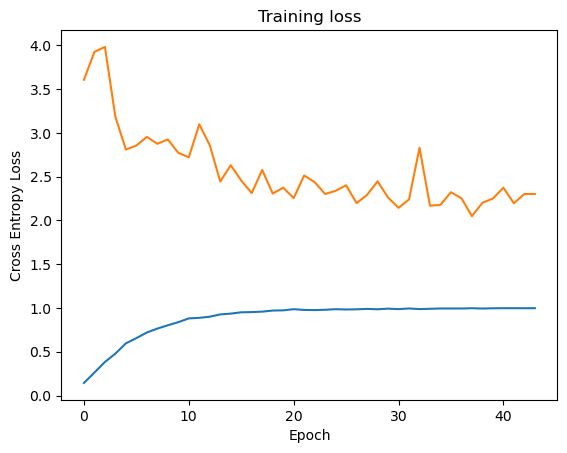

In [12]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

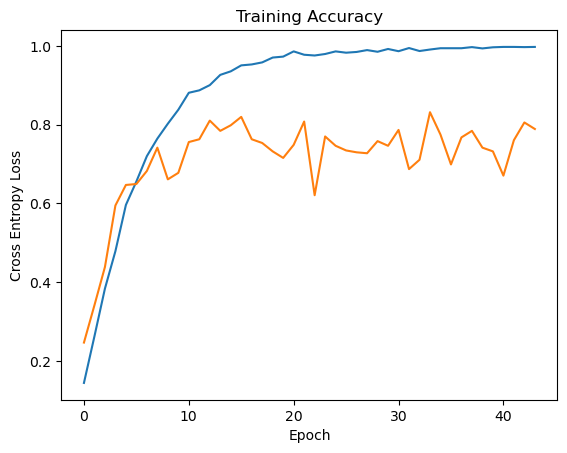

In [13]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

  0%|          | 0/142 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.78      1.00      0.88         7
            bike       1.00      1.00      1.00         5
     bike_helmet       1.00      1.00      1.00         7
        bookcase       0.78      1.00      0.88         7
          bottle       0.25      0.25      0.25         4
      calculator       0.89      1.00      0.94         8
      desk_chair       0.90      0.90      0.90        10
       desk_lamp       0.88      0.88      0.88         8
desktop_computer       0.80      0.62      0.70        13
    file_cabinet       1.00      0.60      0.75        10
      headphones       1.00      0.60      0.75         5
        keyboard       0.88      0.82      0.85        17
 laptop_computer       1.00      0.92      0.96        13
     letter_tray       1.00      0.50      0.67         6
    mobile_phone       1.00      0.89      0.94         9
         monitor       1.00      1.00      1.00         9
           mo

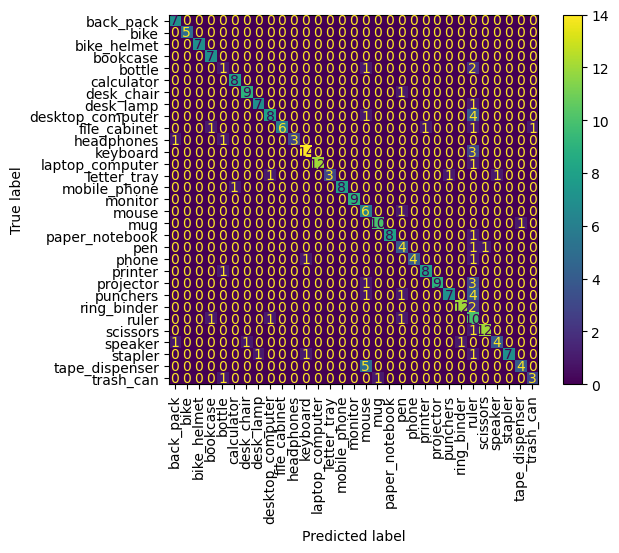

In [14]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.67      0.40      0.50         5
            bike       1.00      0.50      0.67         2
     bike_helmet       0.60      0.75      0.67         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       1.00      0.50      0.67         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.67      0.67      0.67         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

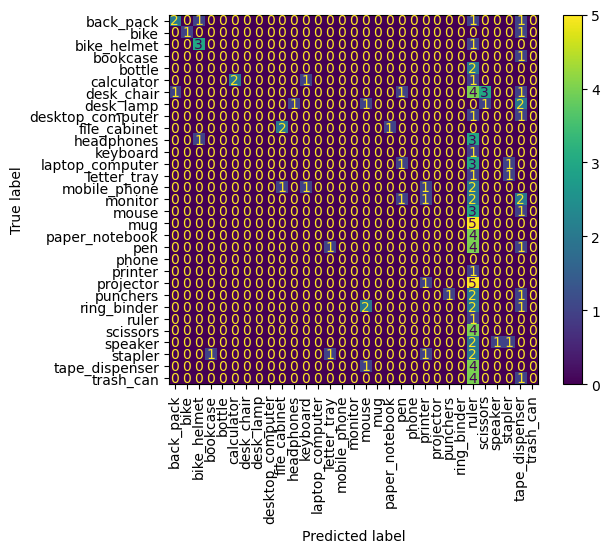

In [15]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [16]:
if TRAIN_UNSUPERVISED_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_MODEL_DIR, "model.pt"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=20,
            rho=3,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

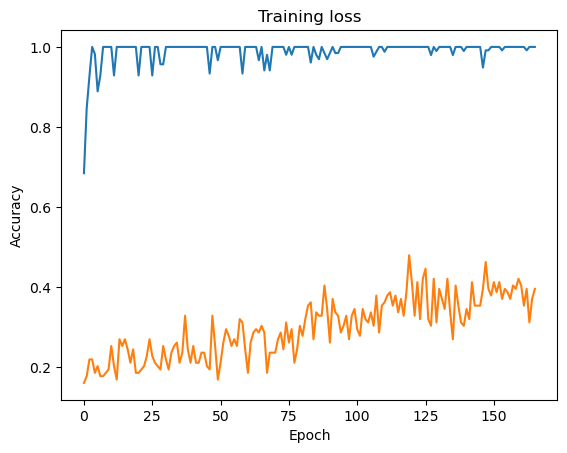

In [17]:
target_history = res["target_history"]

plt.plot(np.array(range(len(target_history["train_acc"]))), target_history["train_acc"])
plt.plot(np.array(range(len(target_history["val_acc"]))), target_history["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training loss")
plt.show()

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.60      0.60      0.60         5
            bike       0.00      0.00      0.00         2
     bike_helmet       1.00      0.75      0.86         4
        bookcase       0.12      1.00      0.22         1
          bottle       0.00      0.00      0.00         2
      calculator       0.40      1.00      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.75      1.00      0.86         3
      headphones       0.40      0.50      0.44         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.50      0.20      0.29         5
         monitor       0.00      0.00      0.00         6
           mo

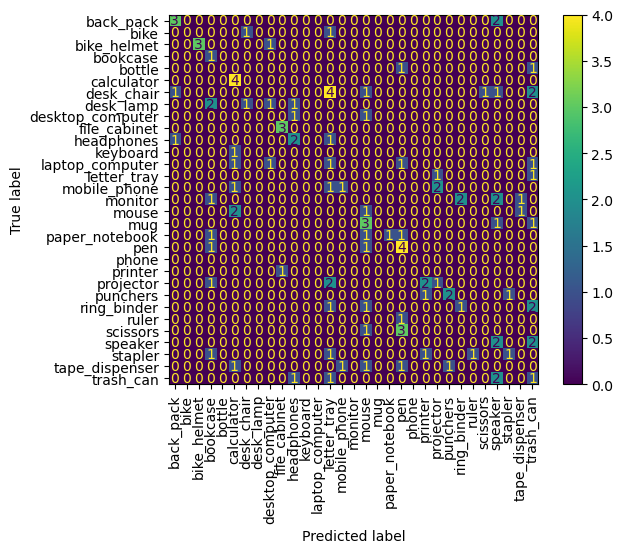

In [18]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

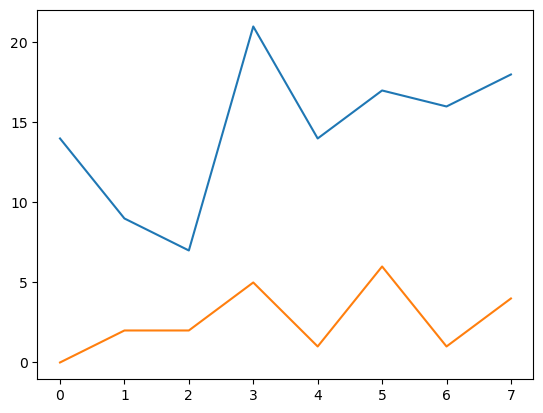

In [19]:
tasks.results.plot_label_history(label_history, encodings)

## Semi-supervised domain adaptation

### 20% target data

In [20]:
if FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history,
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

No history found in path  output/semi-supervised-finetuned-20/label_history.pickle


  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      0.80      0.89         5
            bike       1.00      1.00      1.00         2
     bike_helmet       0.00      0.00      0.00         4
        bookcase       0.00      0.00      0.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       1.00      0.40      0.57         5
desktop_computer       0.20      0.50      0.29         2
    file_cabinet       1.00      0.33      0.50         3
      headphones       0.50      0.25      0.33         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.29      0.40      0.33         5
         monitor       0.00      0.00      0.00         6
           mo

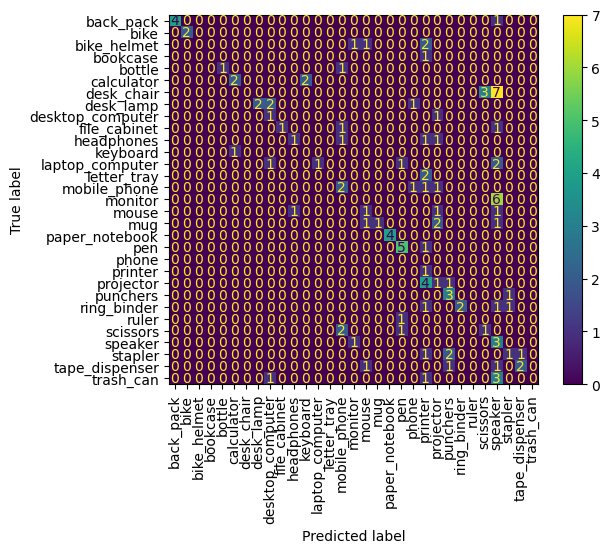

In [21]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [22]:
if TRAIN_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(
        model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt")
    )
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=20,
            rho=4,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.67      0.80      0.73         5
            bike       1.00      1.00      1.00         2
     bike_helmet       1.00      0.50      0.67         4
        bookcase       1.00      1.00      1.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      1.00      0.80         4
      desk_chair       1.00      0.40      0.57        10
       desk_lamp       1.00      0.60      0.75         5
desktop_computer       0.06      0.50      0.11         2
    file_cabinet       0.50      1.00      0.67         3
      headphones       0.75      0.75      0.75         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.50      0.20      0.29         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       1.00      0.40      0.57         5
         monitor       0.00      0.00      0.00         6
           mo

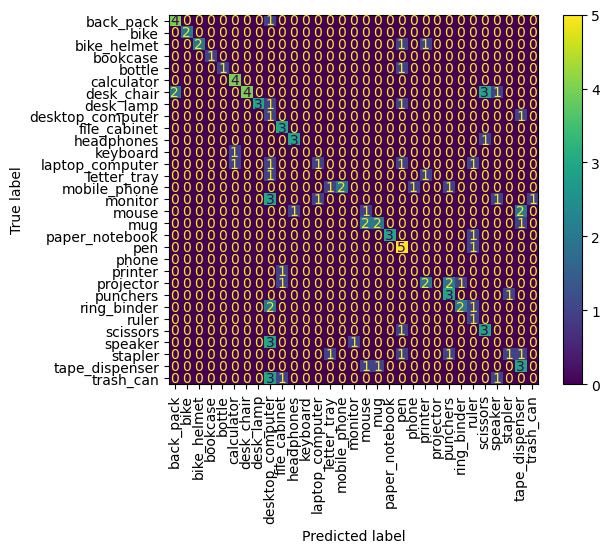

In [23]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

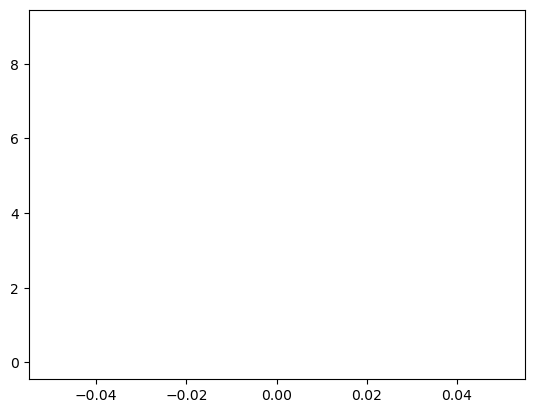

In [24]:
tasks.results.plot_label_history(label_history, encodings)

### 10% target data

In [28]:
if FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = torch.hub.load(
        "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
    ).to(device)
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=None,
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

No history found in path  output/semi-supervised-finetuned-10/source_history.pickle
No history found in path  output/semi-supervised-finetuned-10/target_history.pickle
No history found in path  output/semi-supervised-finetuned-10/label_history.pickle


  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.75      0.60      0.67         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.67      0.50      0.57         4
        bookcase       0.00      0.00      0.00         1
          bottle       1.00      0.50      0.67         2
      calculator       0.67      0.50      0.57         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.33      0.50      0.40         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.67      0.40      0.50         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.29      0.40      0.33         5
         monitor       0.00      0.00      0.00         6
           mo

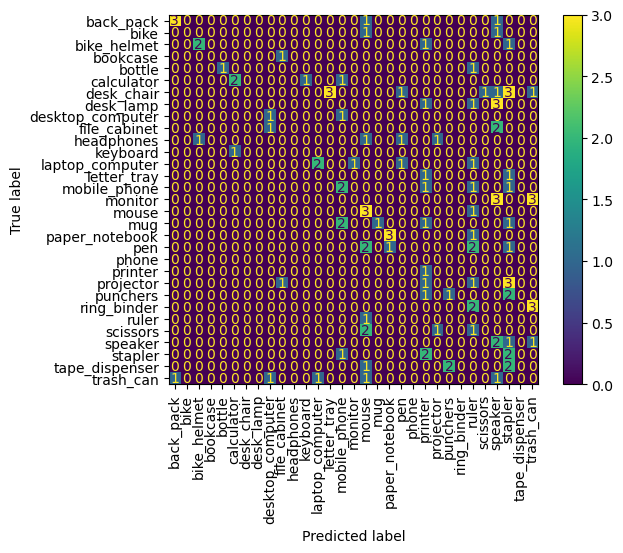

In [29]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [30]:
if TRAIN_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(
        model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt")
    )
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_10,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_10,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=20,
            rho=4,
            previous_source_history=None,
            previous_target_history=None,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

  0%|          | 0/60 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.43      0.75      0.55         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.50      0.50      0.50         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       1.00      0.75      0.86         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       1.00      0.20      0.33         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.14      0.20      0.17         5
         monitor       0.00      0.00      0.00         6
           mo

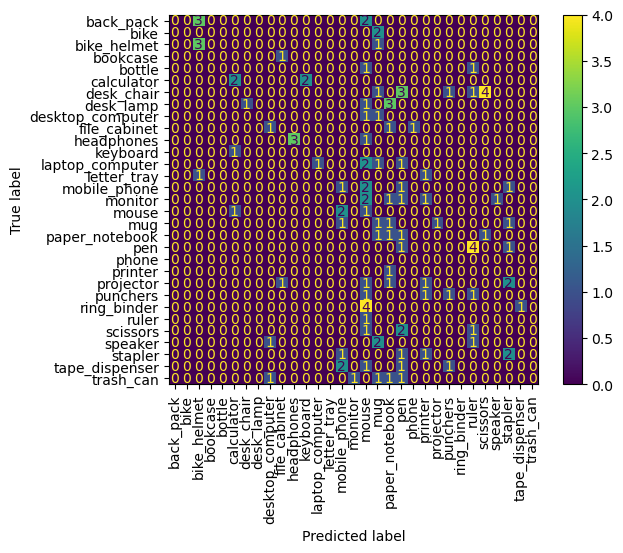

In [31]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

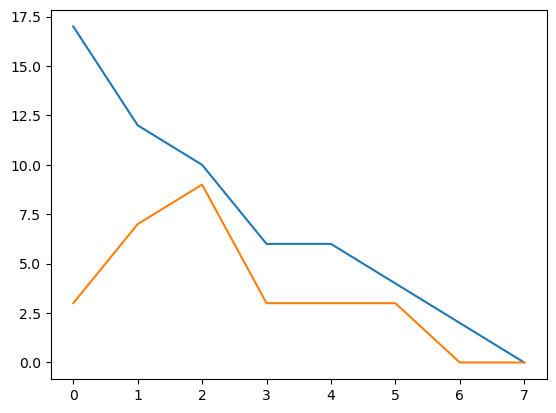

In [32]:
tasks.results.plot_label_history(label_history, encodings)